In [1]:
# Modeling
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV

# Model Selection, Metrics, and Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Data wrangling
import pandas as pd
import numpy as np
import re

# Time
import time
import datetime
from datetime import datetime as dt
import dateutil.parser

# Plotting
import seaborn as sns
from seaborn import plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as pplt

# URL Grabbing
import requests

# Scraping / Searching
from bs4 import BeautifulSoup
import re

# Misc
import pickle
from pprint import pprint

%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_context('poster')
pd.set_option('display.float_format', lambda x: '%.2f' % x) # reduces the amount of decimals when printing the df's

In [2]:
# with open("movies.pkl", 'rb') as picklefile: 
#     df = pickle.load(picklefile)
    
with open("crew.pkl", 'rb') as picklefile: 
    df = pickle.load(picklefile)

In [3]:
# take a peek into the data
df.head().T

,0,1,2,3,4
index,The Other Side of the Mountain Part II,Universal Soldier,Newtown,Mommie Dearest,G.B.F.
actors,NaN,"[Jean-Claude Van Damme, Dolph Lundgren]",NaN,NaN,"[Natasha Lyonne, Megan Mullally]"
close_date,NaT,NaT,NaT,NaT,NaT
composers,NaN,[Tim Simonec],NaN,NaN,NaN
days_in_theater,NaN,NaN,14.00,NaN,NaN
directors,NaN,[Roland Emmerich],NaN,NaN,NaN
domestic_gross_adj,42753500.00,75661200.00,13900.00,59219100.00,NaN
foreign_unadj,NaN,NaN,NaN,NaN,NaN
genre,Romance,Sci-Fi Action,Documentary,Drama,Comedy
mpaa_rating,PG,R,Unrated,PG,R


# Feature Selection

In [4]:
# adding in the months of release
df['release_month'] = df.release_date.dt.month

In [5]:
# dropping all the multidimensional data, that will be engineered later`
df_domestic_pred = df.drop(['actors', 'composers', 'directors', 'producers', 'writers'], 1)

# drop all the unadjusted data
df_domestic_pred = df_domestic_pred.drop(['foreign_unadj', 'worldwide_gross_unadj'], 1)

# dropping all edge cases
df_domestic_pred = df_domestic_pred[(df_domestic_pred.domestic_gross_adj > 10000) & # drop all with significantly low grosses
                                    (df_domestic_pred.mpaa_rating != 'Unrated') & # kills all unrated
                                    (df_domestic_pred.runtime >= 40) & # drop all movies less than feature length
                                    (df_domestic_pred.release_date.dt.year >= 1990)] # remove all unrated

# dropping highly correlated data (and intertwined)
df_domestic_pred = df_domestic_pred.drop(['opening_weekend_adj'], 1)

In [6]:
print('Number of rows:',len(df_domestic_pred))
df_domestic_pred.head().T

Number of rows: 5496


,1,5,6,7,8
index,Universal Soldier,Saw IV,Better Than Chocolate,The Jackal,Murderball
close_date,NaT,2007-12-13 00:00:00,NaT,NaT,2005-10-06 00:00:00
days_in_theater,NaN,49.00,NaN,NaN,91.00
domestic_gross_adj,75661200.00,79585200.00,3431700.00,103517800.00,2066200.00
genre,Sci-Fi Action,Horror,Romantic Comedy,Action Thriller,Documentary
mpaa_rating,R,R,R,R,R
number_of_theaters,1925.00,3183.00,130.00,2309.00,97.00
production_budget_adj,NaN,NaN,NaN,60000000.00,NaN
release_date,1992-07-10 00:00:00,2007-10-26 00:00:00,1999-08-13 00:00:00,1997-11-14 00:00:00,2005-07-08 00:00:00
runtime,102.00,108.00,102.00,125.00,88.00


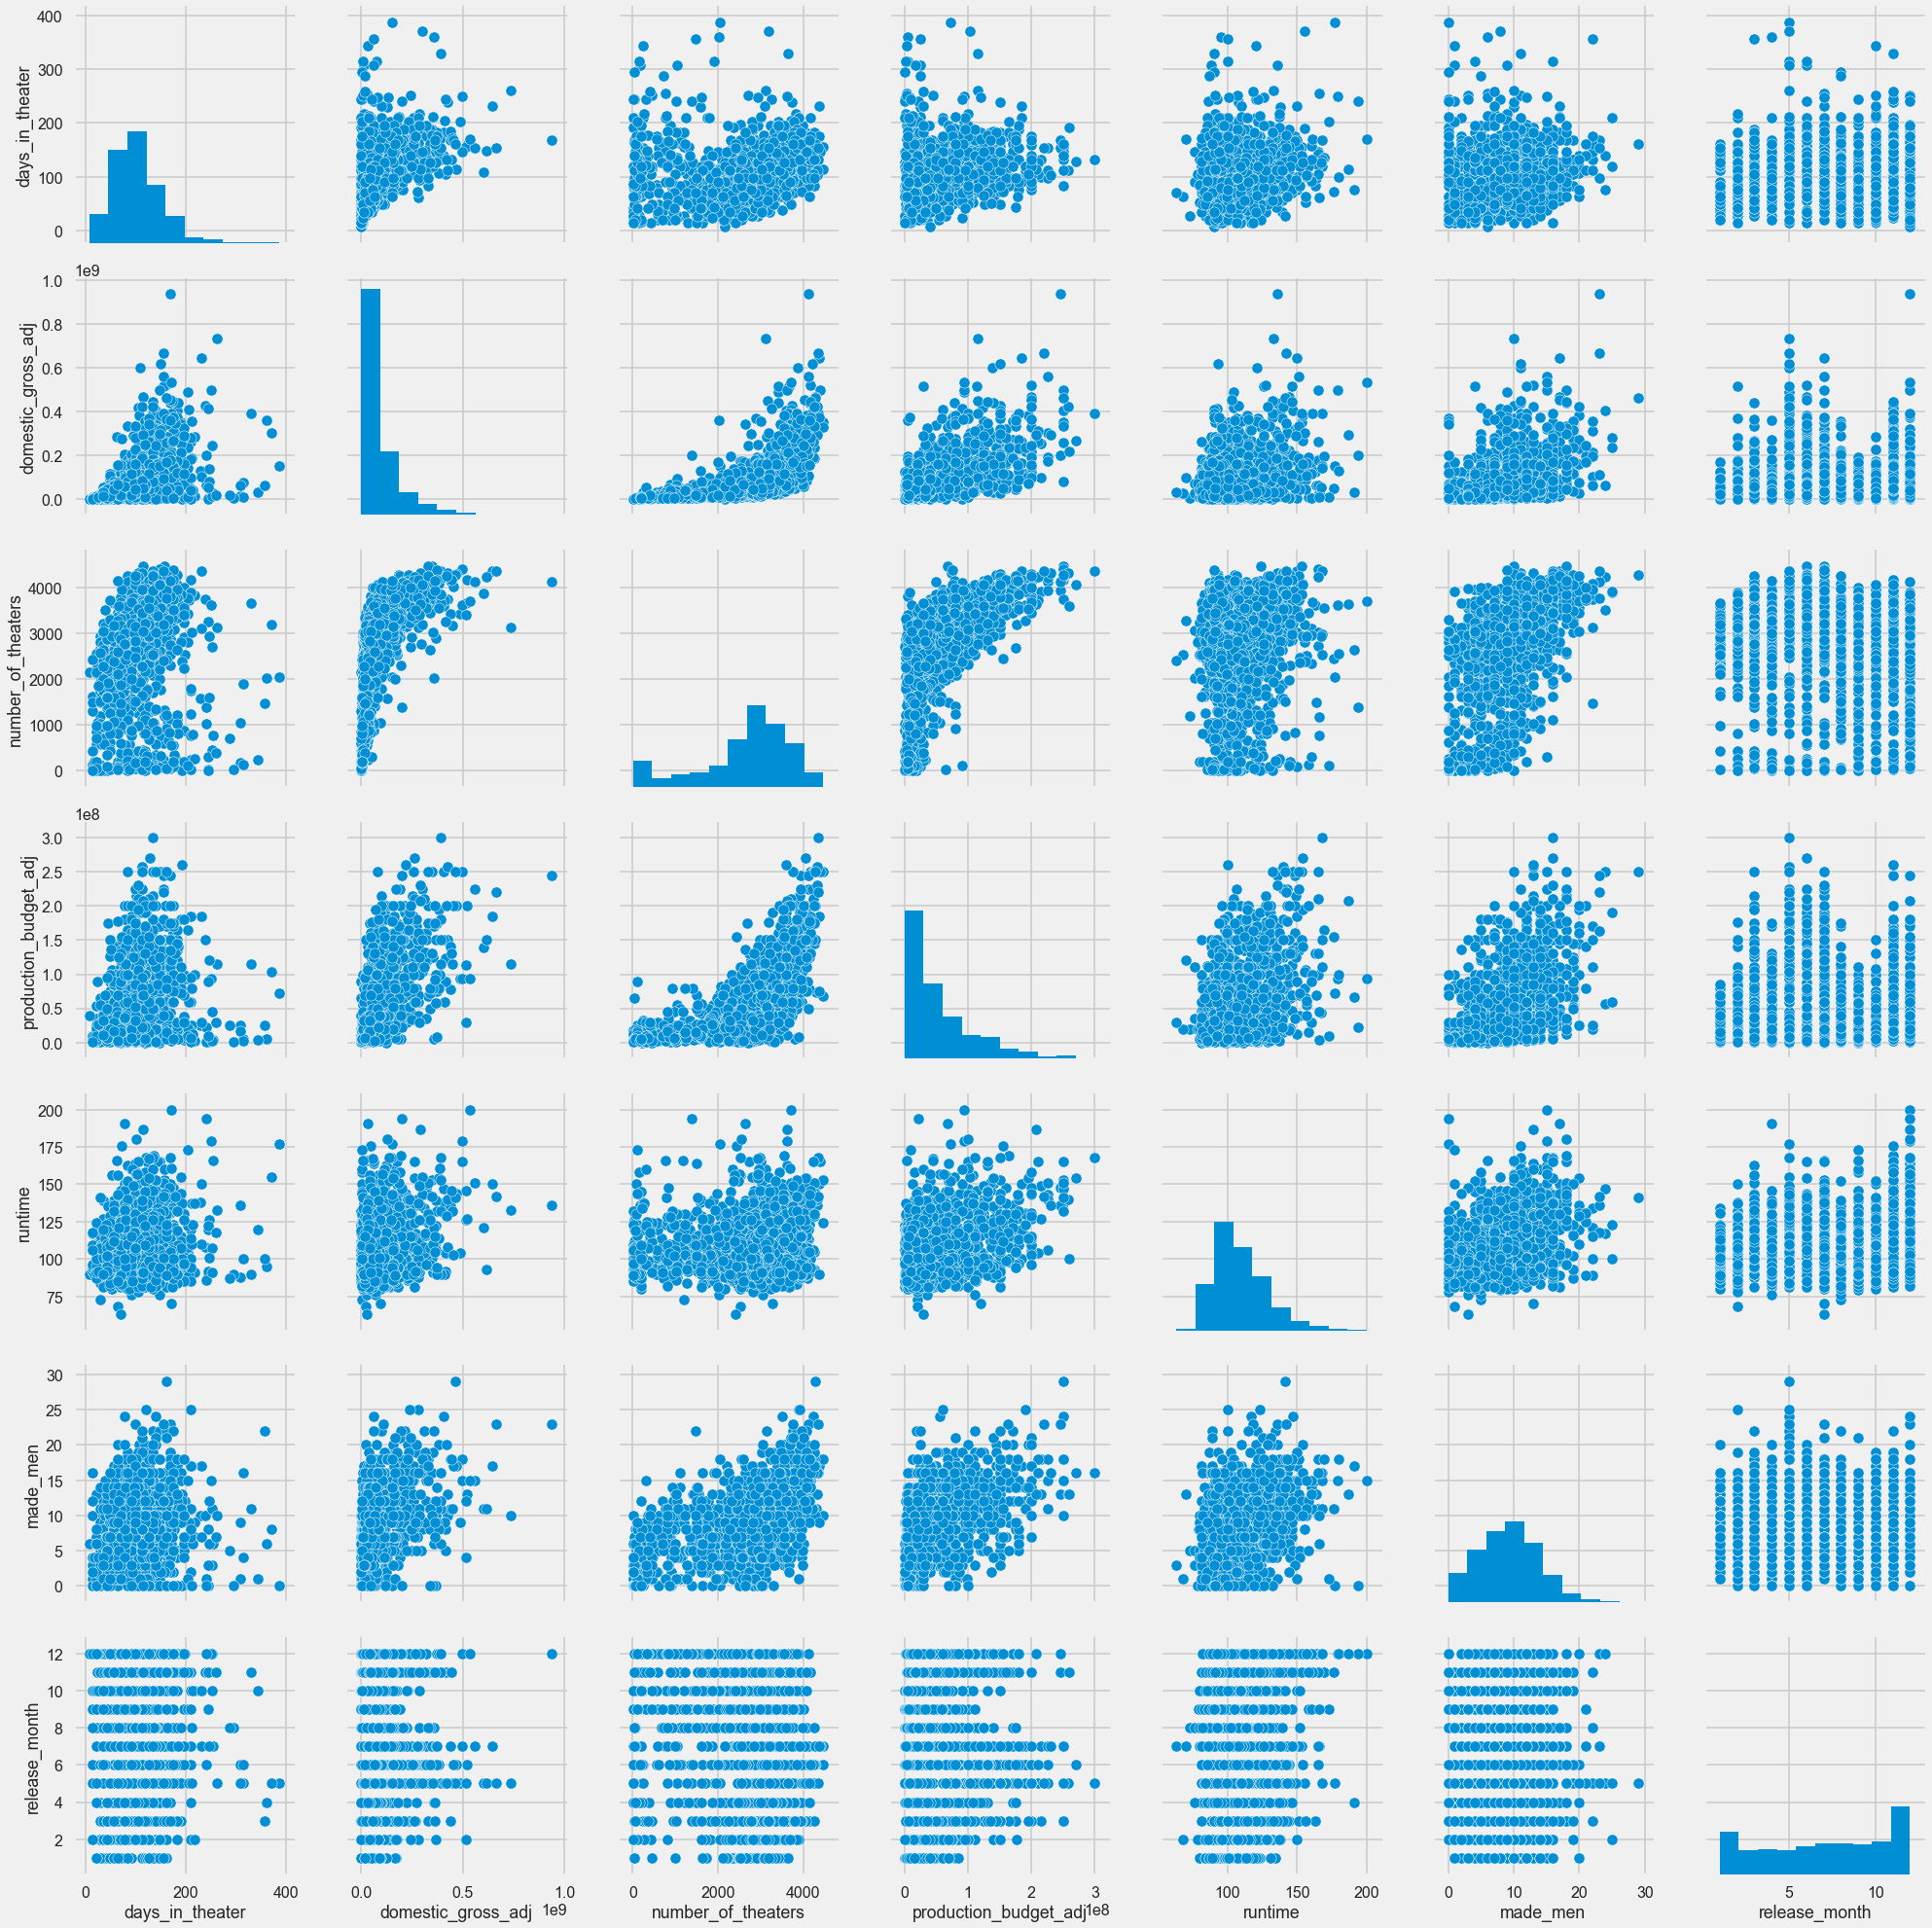

In [7]:
sns.pairplot(df_domestic_pred.dropna(), size=4);

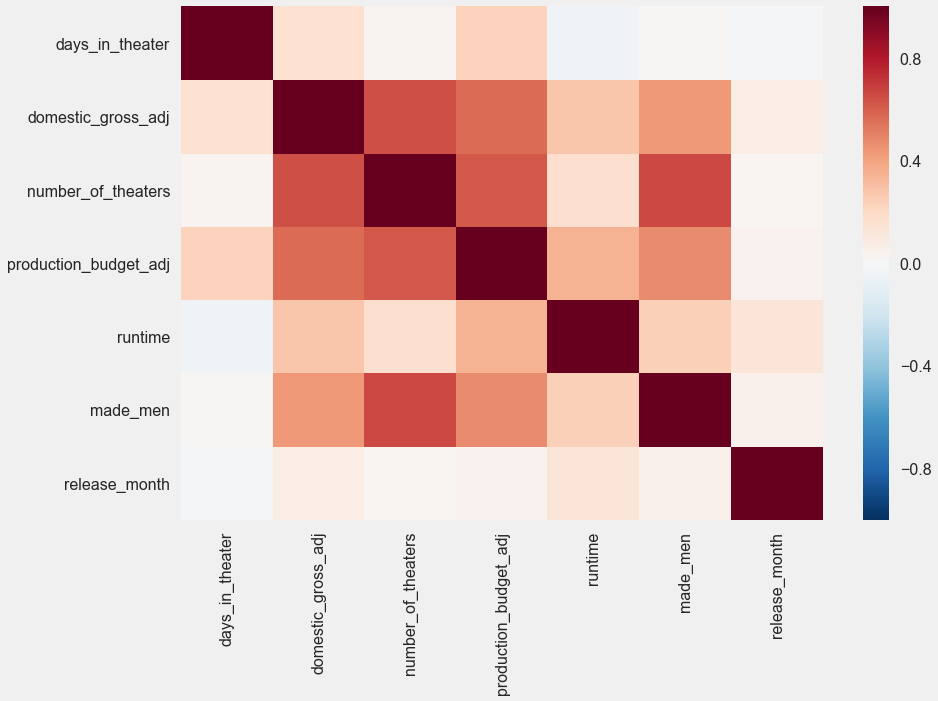

In [8]:
# checking the correlations for any intracorrelations
sns.heatmap(df_domestic_pred.corr());

# Transformation  
  
Here we take a stab at transforming all the data into a normal form

In [9]:
sns.set_context('notebook')

### Before Transformation

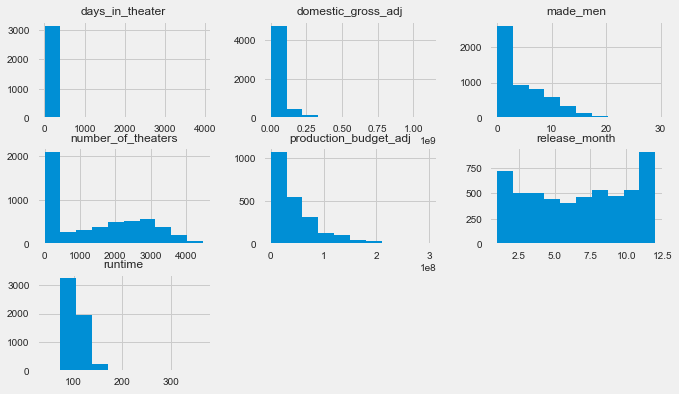

In [10]:
# Checking if any values need to be transformed
df_domestic_pred.hist(figsize=(10,6));

Production Budget (log)

In [11]:
df_domestic_pred['production_budget_log'] = df_domestic_pred['production_budget_adj'].apply(np.sqrt)
df_domestic_pred.drop(['production_budget_adj'], 1);
# df_domestic_pred['production_budget_log'].hist();

Days In Theater (log)

In [12]:
df_domestic_pred['days_in_theater_log'] = df_domestic_pred['days_in_theater'].apply(np.log)
df_domestic_pred.drop(['days_in_theater'], 1);
# df_domestic_pred['days_in_theater_log'].hist();

Runtime (log)

In [13]:
# df_domestic_pred['runtime'].apply(np.log).hist()
df_domestic_pred['runtime_log'] = df_domestic_pred['runtime'].apply(np.log)
df_domestic_pred.drop(['runtime'], 1);
# df_domestic_pred['runtime_log'].hist();

In [14]:
# df_domestic_pred['made_men_log'] = df_domestic_pred['made_men'].apply(np.log)
# df_domestic_pred.drop(['days_in_theater'], 1)
# df_domestic_pred['days_in_theater_log'].hist();
# df_domestic_pred[df_domestic_pred.made_men == np.nan]
# df_domestic_pred['made_men'].hist();

#### Cleaning

In [15]:
# choose the predicted columns
df_domestic_pred = df_domestic_pred[['domestic_gross_adj', 'production_budget_log', 'made_men',
                                     'runtime_log', 'days_in_theater_log', 'number_of_theaters',
                                     'release_month']]

In [16]:
# kill off any NA 
df_domestic_pred = df_domestic_pred.dropna()#subset=['domestic_gross_adj', 'production_budget_log', 
                                            #       'runtime_log', 'days_in_theater_log', 'number_of_theaters'])

In [17]:
print('Number of Films after Filtering:',len(df_domestic_pred))
df_domestic_pred.head()

Number of Films after Filtering: 1437


,domestic_gross_adj,production_budget_log,made_men,runtime_log,days_in_theater_log,number_of_theaters,release_month
10,195732200.00,2236.07,14,4.70,4.34,3807.00,8.00
11,55815700.00,4472.14,2,4.70,4.34,2762.00,6.00
18,18664000.00,7745.97,9,4.62,4.25,2215.00,11.00
25,176014600.00,6557.44,7,4.76,5.12,3184.00,6.00
32,352178200.00,8602.33,11,4.51,5.08,4311.00,7.00


### After Transformation

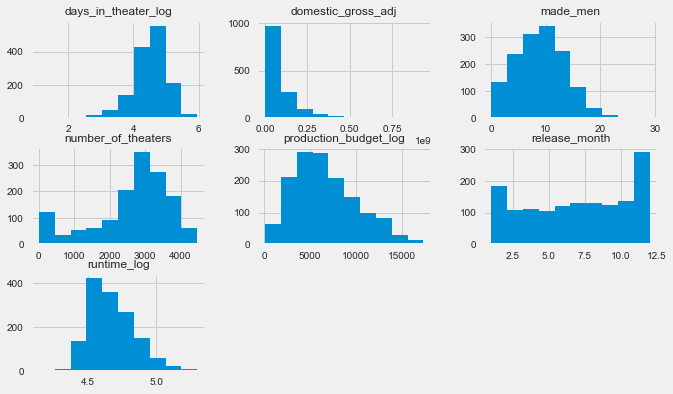

In [18]:
df_domestic_pred.hist(figsize=(10,6));

# Splitting & Preparing the Data

Avoiding normalization for now, will be toggled in our models

In [19]:
# Holding onto the df for any use
X_df = df_domestic_pred.iloc[:, 1:]
y_df = df_domestic_pred.iloc[:, 0]

# Choose the predictor variables, here all but the first which is the response variable
# This model is analogous to the Y ~ X1 + X2 + X3 + X4 + X5 + X6 model
X = np.array(X_df)

# Choose the response variable(s)
y = np.array(y_df)

In [20]:
# train / test splits
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [21]:
print('shapes:')
print('X_train:',X_train.shape)
print('X_test:',X_test.shape)
print('y_train:',y_train.shape)
print('y_test:',y_test.shape)

shapes:
X_train: (1077, 6)
X_test: (360, 6)
y_train: (1077,)
y_test: (360,)


In [22]:
# # first normalize our features
# X = preprocessing.normalize(X_train, axis=0)

# # turn back in DF
# df_domestic_pred_norm = pd.DataFrame(domestic_pred_norm, columns=df_domestic_pred.columns)

# Plotting Functions

In [23]:
def plot_approximation(est, ax, label=None):
    """Plot the approximation of ``est`` on axis ``ax``. """
    ax.scatter(X_train[:,0], y_train, s=50)
    ax.plot(x_plot, est.predict(x_plot), color='red', label=label)
    ax.set_ylim(-10000000, max(y))
#     ax.set_xlim(0, max(X[0]))
    ax.set_ylabel('y')
    ax.set_xlabel('x')
    ax.legend(loc='upper right',frameon=True)

In [24]:
def plot_coefficients(est, ax, label=None, yscale='log'):
    """A helper function to plot the absolute value of the coefficients on the right-hand column plot
    """
    coef = est.steps[-1][1].coef_.ravel() # i have 0 idea how this works
    if yscale == 'log':
        ax.semilogy(np.abs(coef), marker='o', label=label)
        ax.set_ylim((1e-1, 1e8))
    else:
        ax.plot(np.abs(coef), marker='o', label=label)
    ax.set_ylabel('abs(coefficient)')
    ax.set_xlabel('coefficients')
    ax.set_xlim((0, 10))
    ax.set_ylim(-1000,1e6)

In [25]:
def plot_residuals(est, features=X_test):
    fig = plt.figure(figsize=(5,5))
    ax = plt.axes()
    ax.plot(y_test - est.predict(features), features[:,1], marker='o', ls='')
    
    return ax

In [26]:
def plot_poly_error(est, order):
    train_error = np.empty(order)
    test_error = np.empty(order)
    for degree in range(order):
        model = make_pipeline(PolynomialFeatures(degree), est)
        model.fit(X_train, y_train)
        train_error[degree] = mean_squared_error(y_train, model.predict(X_train))
        test_error[degree] = mean_squared_error(y_test, model.predict(X_test))

    # Plot the training and test errors against degree
    plt.figure(figsize=(8,6))
    plt.plot(np.arange(order), train_error, color='green', label='train')
    plt.plot(np.arange(order), test_error, color='red', label='test')
    plt.ylabel('log(mean squared error)')
    plt.xlabel('degree')
    plt.xticks(range(order))
    plt.legend(loc='upper left')

In [27]:
def plot_actual_predicted(est, features=X_test):
    fig = plt.figure(figsize=(5,5))
    ax = plt.axes()
    line = np.linspace(y_test.min(), y_test.max(), 360)

    ax.plot(y_test, est.predict(X_test), marker='o', ls='')
    ax.plot(line, line)
    
    min_val = min(ax.get_xlim()[0],ax.get_ylim()[0])
    max_val = max(ax.get_xlim()[1],ax.get_ylim()[1])
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)

In [28]:
def linear_Matrix(matrix):
    """Returns a linearly spaced numpy matrix based on the same size of the input matrix.
    Matrix must be larger than 1 column.s
    """
    m, n = matrix.shape
    n_matrix = np.zeros((m,n))
    for i in range(n):
        n_matrix[:,i] = np.linspace(matrix[:,i].min(), matrix[:,i].max() + 1, m)
    return n_matrix

In [29]:
# Building an m x n dimensional matrix
x_plot = linear_Matrix(X_train)

# Building the Predictive Model

### Parameters

## Linear Regression (No Regularization)

Ordinary least squares Linear Regression.  
http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression

In [33]:
# Create an empty model
linear = LinearRegression(normalize=True)

# Fit the model to the full dataset
linear.fit(X_train, y_train)

# store the prediction
y_pred = linear.predict(X_test)

# Print out the metrics for the model against the full dataset
print('R^2 :',linear.score(X_train,y_train))
print('MSE :',mean_squared_error(y_pred, y_test))

R^2 : 0.503881365513
MSE : 5.58282886646e+15


In [ ]:
X_df.head()

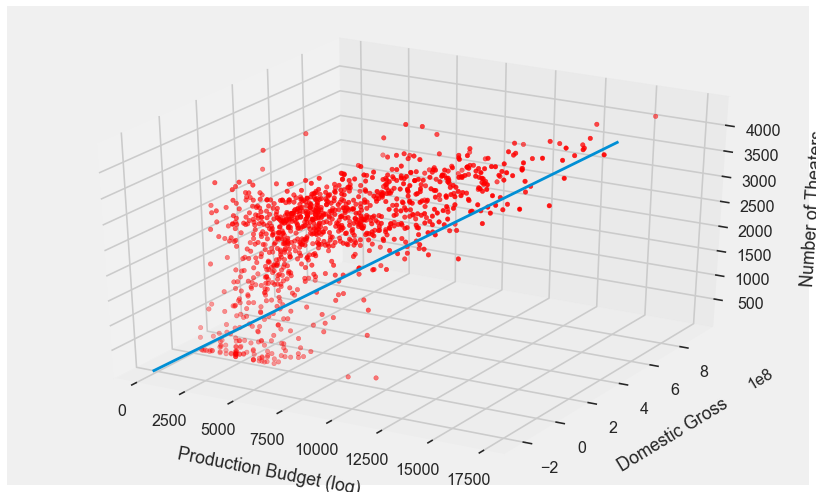

In [45]:
%matplotlib inline
sns.set_context('poster')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.tick_params(direction='out')

line_matrix = linear_Matrix(np.array([X[:,0], y, X[:,4]]).T)

ax.plot(x_plot[:,0], linear.predict(x_plot), x_plot[:,4] )
ax.scatter(X_train[:,0], y_train, X_train[:,4], c='r', marker='o')

ax.set_xlabel('Production Budget (log)', labelpad=30)
ax.set_ylabel('Domestic Gross', labelpad=30)
ax.set_zlabel('Number of Theaters', labelpad=30)

# ax.set_xlim(X_train[:,0].min(), X_train[:,0].max())
# ax.set_ylim(y.min(), y.max())
ax.set_zlim(X_train[:,4].min(), X_train[:,4].max())

plt.show()

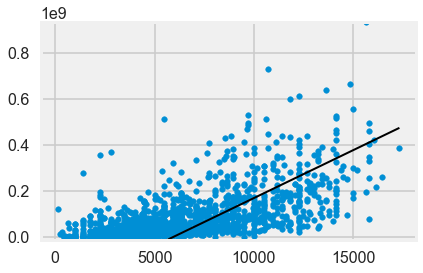

In [39]:
%matplotlib inline
# Checking the model's shape against the heaviest correlated value
plt.scatter( X[:,0], y, marker='.' )
plt.plot( x_plot.T[0].T, linear.predict(x_plot), linewidth=2, color='k' )
ax = plt.gca()
ax.set_ylim(-10000000, max(y));
# ax.set_xlim(-0.01, max(x_plot[0]))

## Polynomial Linear Regression

Some features look good here..

In [46]:
poly_linear = make_pipeline(PolynomialFeatures(3), LinearRegression(normalize=True))
poly_linear.fit(X_train, y_train)
poly_linear.score(X_train, y_train)

0.73396357502053844

In [47]:
X_test_poly = preprocessing.normalize(X_test, axis=0)
poly_y_pred = poly_linear.predict(X_test_poly)

In [48]:
pd.DataFrame(list(zip(X_df.columns,poly_linear.steps[1][-1].coef_)), columns=['features', 'coefficients'])

,features,coefficients
0,production_budget_log,-0.00
1,made_men,-1549123.44
2,runtime_log,-29374206.91
3,days_in_theater_log,6432002279.56
4,number_of_theaters,-627255528.64
5,release_month,5971219.28


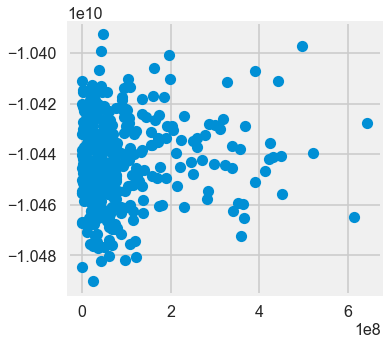

In [49]:
%matplotlib inline
fig = plt.figure(figsize=(5,5))
ax = plt.axes()

ax.plot(y_test,poly_y_pred, marker='o', ls='');
# min_val = min(ax.get_xlim()[0],ax.get_ylim()[0])
# max_val = max(ax.get_xlim()[1],ax.get_ylim()[1])
# ax.set_xlim(0, max_val)
# ax.set_ylim(min_val, max_val)

NameError: name 'poly_linear' is not defined

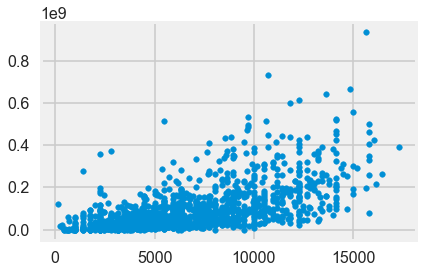

In [41]:
%matplotlib inline
# Checking the model's shape against the heaviest correlated value
plt.scatter(X[:,0], y, marker='.')
plt.plot( x_plot.T[0].T, poly_linear.predict(x_plot), linewidth=2, color='k' )
ax = plt.gca()
ax.set_ylim(-10000000, max(y))
# ax.set_xlim(-0.01, 0.065)

# plt.yticks( np.arange(0,1000000000,100000000) );

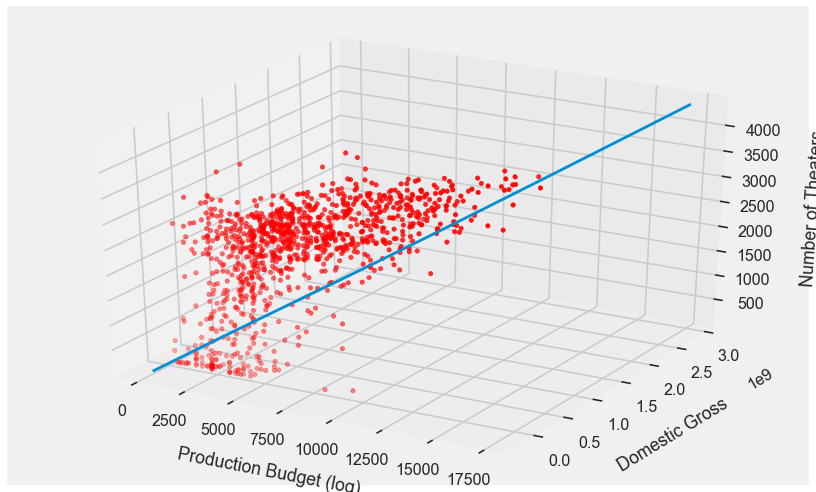

In [50]:
%matplotlib inline
sns.set_context('poster')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.tick_params(direction='out')

line_matrix = linear_Matrix(np.array([X[:,0], y, X[:,4]]).T)

ax.plot(x_plot[:,0], poly_linear.predict(x_plot), x_plot[:,4] )
ax.scatter(X_train[:,0], y_train, X_train[:,4], c='r', marker='o')

ax.set_xlabel('Production Budget (log)', labelpad=30)
ax.set_ylabel('Domestic Gross', labelpad=30)
ax.set_zlabel('Number of Theaters', labelpad=30)

# ax.set_xlim(X_train[:,0].min(), X_train[:,0].max())
# ax.set_ylim(y.min(), y.max())
ax.set_zlim(X_train[:,4].min(), X_train[:,4].max())

plt.show()

In [ ]:
plot_poly_error(LinearRegression(normalize=True), order=5)

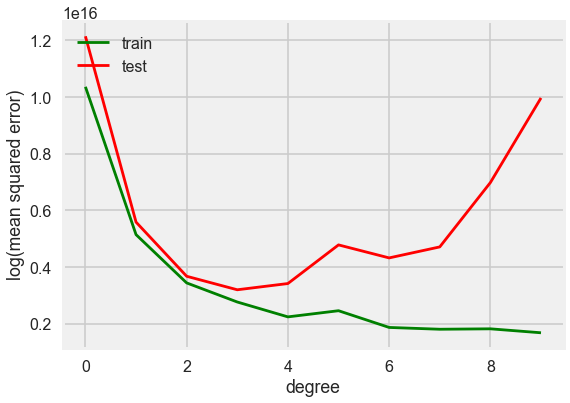

In [51]:
# Step through degrees from 0 to 9 and store the training and test (generalization) error.
# create array of zeros,
train_error = np.empty(10)
test_error = np.empty(10)
for degree in range(10):
    poly_linear = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    poly_linear.fit(X_train, y_train)
    train_error[degree] = mean_squared_error(y_train, poly_linear.predict(X_train))
    test_error[degree] = mean_squared_error(y_test, poly_linear.predict(X_test))

# Plot the training and test errors against degree
plt.figure(figsize=(8,6))
plt.plot(np.arange(10), train_error, color='green', label='train')
plt.plot(np.arange(10), test_error, color='red', label='test')
plt.ylabel('log(mean squared error)')
plt.xlabel('degree')
plt.legend(loc='upper left')

To address the high bias of the degrees of 2 or 3 degrees looks like a good start

I'm beginning to understand the struggle to get the right model!  
Let's try passing this to a lasso

## Lasso

In [ ]:
np_lasso = LassoCV(normalize=True, cv=5)
np_lasso = np_lasso.fit(X_train, y_train)

y_pred = np_lasso.predict(X_test)

In [ ]:
%matplotlib inline
plot_actual_predicted(np_lasso)

In [ ]:
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.tick_params(direction='out')

# n = 100

# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
# for c, m, zlow, zhigh in [('r', 'o', -50, -25), ('b', '^', -30, -5)]:
#     xs = randrange(n, 23, 32)
#     ys = randrange(n, 0, 100)
#     zs = randrange(n, zlow, zhigh)
#     ax.scatter(xs, ys, zs, c=c, marker=m)

# line_matrix = linear_Matrix(np.array([X[:,0], y, X[:,4]]).T)

ax.plot(x_plot[:,0], np_lasso.predict(x_plot), x_plot[:,4] )
ax.scatter(X_train[:,0], y_train, X_train[:,4], c='r', marker='o')



ax.set_xlabel('Production Budget (log)', labelpad=30)
ax.set_ylabel('Domestic Gross', labelpad=30)
ax.set_zlabel('Number of Theaters', labelpad=30)

# ax.set_xlim(X_train[:,0].min(), X_train[:,0].max())
# ax.set_ylim(y.min(), y.max())
ax.set_zlim(X_train[:,4].min(), X_train[:,4].max())



plt.show()

## Polynomial Lasso  
Least absolute shrinkage and selection operator  
https://en.wikipedia.org/wiki/Lasso_(statistics)

In [ ]:
degrees = 4
pf = PolynomialFeatures(degrees)

X_train_pf = pf.fit_transform(X_train)
X_test_pf =  pf.transform(X_test)

lasso_plot = linear_Matrix(X_train_pf)

lasso = LassoCV(normalize=True, cv=5)
lasso = lasso.fit(X_train_pf, y_train)

y_pred = lasso.predict(X_test_pf)
lasso.score(X_train_pf, y_train)

In [ ]:
%matplotlib inline
fig = plt.figure(figsize=(5,5))
ax = plt.axes()
line = np.linspace(y_test.min(), y_test.max(), 360)

ax.plot(y_test, y_pred, marker='o', ls='', ms=5)
ax.plot(line, line)

min_val = min(ax.get_xlim()[0],ax.get_ylim()[0])
max_val = max(ax.get_xlim()[1],ax.get_ylim()[1])
ax.set_xlim(min_val, max_val)
ax.set_ylim(min_val, max_val);

In [ ]:
plt.plot?

In [ ]:
len(pf.get_feature_names())

In [ ]:
%matplotlib notebook
sns.set_context('poster')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(lasso_plot[:,1], lasso.predict(lasso_plot), lasso_plot[:,5] )
ax.scatter(X_train_pf[:,1], y_train, X_train_pf[:,5], c='r', marker='o')

ax.tick_params(direction='out')

ax.set_xlabel('Production Budget (log)', labelpad=30)
ax.set_ylabel('Domestic Gross', labelpad=30)
ax.set_zlabel('Number of Theaters', labelpad=30)

# ax.set_xlim(X_train[:,0].min(), X_train[:,0].max())
# ax.set_ylim(y.min(), y.max())
ax.set_zlim(X_train[:,4].min(), X_train[:,4].max())

plt.show()

In [ ]:
# # Checking the model's shape against the heaviest correlated value
# plot_matrix = preprocessing.normalize(linear_Matrix(X_test_pf))
# plot_pred = preprocessing.normalize(lasso.predict(plot_matrix).T)

# plt.scatter(preprocessing.normalize(X_test[:,0]), preprocessing.normalize(y_test), marker='.')
# plt.plot(plot_matrix[:,0] , plot_pred, linewidth=2, color='k' )
# ax = plt.gca()

In [ ]:
lasso.alpha_, lasso.coef_

In [ ]:
np.log(mean_squared_error(y_test, y_pred))

#### Revisit ...

In [ ]:
plot_poly_error(LassoCV(normalize=True, cv=5), 5)

In [ ]:
# This finds all the errors in the model with different alphas

kf = KFold(n_splits=5, shuffle=True)

degree = 2
max_iterations = 20000
poly_lasso = make_pipeline(PolynomialFeatures(degree), Lasso())
poly_lasso.set_params(lasso__max_iter=max_iterations) # to ensure convergence

# preset the alphas we want to test
alphas = [1e-8, 1e-5, 1, 10, 100, 1000]
errors = []

for i in alphas:
    poly_lasso.set_params(lasso__alpha=i)
    poly_lasso.fit(X,y)
    error = mean_squared_error(y, poly_lasso.predict(X))
    errors.append(error)

errors

In [ ]:
# Looking at above, the lower the penalty on the coefficients, the better?
poly_lasso.set_params(lasso__alpha=1e-8)
np.mean(y_test - poly_lasso.predict(X_test))

In [ ]:
# # Checking the model's shape against the heaviest correlated value
# plt.scatter(X_train[:,0], y_train, marker='.') # production budget vs domestic gross
# plt.plot( x_plot.T[0].T, lasso.predict(X_train), linewidth=2, color='k' ) # plot against data
# ax = plt.gca() 
# ax.set_ylim(-0.01, 0.19)
# ax.set_xlim(-0.01, 0.065)

In [ ]:
# this determines the best coefficients 
all_scores = []

for train, test in kf.split(X):
    x_tr = X.iloc[train]
    y_tr = y.iloc[train]
    x_te = X.iloc[test]
    y_te = y.iloc[test]
    mse_score = []
    for i in alphas:
        lasso.set_params(lasso__alpha=i)
        lasso.fit(x_tr,y_tr)
        mse = np.mean((y_te - lasso.predict(x_te))**2)
        mse_score.append(mse)
    all_scores.append(mse_score)

zipped = zip(X.columns, lasso.coef_)
features = sorted(zipped, key = lambda x: abs(x[1]), reverse=True)
for f in features[:]:
    print ("{:20.20s} {:7.3f}".format(f[0], f[1]))

## Ridge Regression


http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html#sklearn.linear_model.RidgeCV

In [ ]:
plot_poly_error(RidgeCV(alphas=[1,10,100], normalize=True, cv=5), 5);

In [ ]:
# Set up a figure and axes for 8 plots, 2 per row for 4 rows
fig, ax_rows = plt.subplots(4, 2, figsize=(15, 20))

degree = 3
alphas = [0.0, 1e-8, 1e-5, 1]
for alpha, ax_row in zip(alphas, ax_rows):
    ax_left, ax_right = ax_row
    est = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=alpha, normalize=True))
    est.fit(X_train, y_train)
    plot_approximation(est, ax_left, label='alpha=%r' % alpha)
    plot_coefficients(est, ax_right, label='Ridge(alpha=%r) coefficients' % alpha)

plt.tight_layout()

## Elastic Net

In [ ]:
%matplotlib inline

In [ ]:
enet = ElasticNetCV(alphas = [1e-5,1e-3,1e-1,1,100],
                    l1_ratio = [0.1,0.9,0.5],
                    normalize=True, 
                    cv=5,
                    random_state=9)
enet = enet.fit(X_train, y_train)

y_pred = enet.predict(X_test)

In [ ]:
enet.score(X_test, y_test)

In [ ]:
plot_residuals(enet);

In [ ]:
plot_actual_predicted(enet)

In [ ]:
enet.alpha_
enet.l1_ratio_

In [ ]:
mean_squared_error(y_test,enet.predict(X_test))